# 基于 TPLC 产量预测的丹参温室分层优化控制系统

## 架构概述
本系统采用**双层优化架构 (Two-Layer Optimization Architecture)**，实现决策与控制的解耦：

1.  **决策层 (Decision Layer)**：
    *   **目标**：最大化 TPLC 模型预测的丹参产量。
    *   **输入**：当前环境状态、TPLC 预测模型。
    *   **输出**：最优环境设定值曲线（Target Setpoints，如未来 24H 温度曲线）。
    *   **算法**：**ISSA (Improved Sparrow Search Algorithm)** - 单目标高效寻优算法，用于在复杂的TPLC预测曲面上寻找最高产的环境配置。

2.  **控制层 (Control Layer)**：
    *   **目标**：多目标优化
        1.  **最小化跟踪误差 (Tracking Error)**：确保环境紧跟决策层的设定值。
        2.  **最小化能耗 (Energy Consumption)**：在保证控制效果的同时降低执行器成本。
    *   **输入**：决策层输出的设定值曲线。
    *   **输出**：最优 PID 控制参数 ($K_p, K_i, K_d$)。
    *   **算法**：**MOSSA (Multi-Objective Salp Swarm Algorithm)** - 寻找误差与能耗之间的 Pareto 最优解。

## 优势
*   **逻辑解耦**：将“种得好”（农学目标）与“控得稳/省钱”（控制/经济目标）分离。
*   **层级适配**：决策层追求极值（单目标ISSA），控制层追求平衡（多目标MOSSA）。
*   **发挥 TPLC 强项**：TPLC 专注于复杂的生物生长预测，而不直接参与底层执行器控制。

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目路径以导入模块
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir) # degree_code_scheme_1
pid_path = os.path.join(project_root, 'scheme_1_PID')

if pid_path not in sys.path:
    sys.path.append(pid_path)

print(f"Added search path: {pid_path}")

# 尝试导入核心模块
try:
    from MOSSA import MOSSA
    from issa import ISSAOptimizer  # 导入单目标优化器 ISSA
    from greenhouse_env import VirtualGreenhouse
    from pid import PIDController
    print("Modules imported successfully.")
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("Please ensure MOSSA.py, issa.py, greenhouse_env.py, and pid.py are in ../scheme_1_PID/")

Added search path: d:\degree_code_scheme_1\scheme_1_PID
Modules imported successfully.


## 1. 模拟 TPLC 预测模型 (Stub)
在实际部署中，这里将加载训练好的 PyTorch 模型 (`TPLC_Net`)。为了演示架构，我们构建一个模拟的产量预测函数。

*假设：温度在 25℃ 左右且光照适宜时，产量(生物量积累)最高。*

In [2]:
class TPLC_Model_Wrapper:
    def __init__(self, model_path=None):
        self.model = None # 这里应加载 torch.load(model_path)
        print("TPLC Model Stub Initialized")

    def predict_yield(self, env_vars):
        """
        模拟 TPLC 预测功能
        env_vars: [温度, 湿度, CO2, 光照] 的均值或序列
        返回: 预测的生长增量
        """
        # 简化的模拟逻辑：
        # 只有在特定范围内生长才快
        # 最佳温度 25, 最佳湿度 70%, 最佳 CO2 600, 最佳光照 500
        temp, hum, co2, light = env_vars
        
        score_t = -1.0 * (temp - 25)**2 + 100
        score_h = -0.5 * (hum - 70)**2 + 100
        score_c = -0.1 * (co2 - 600)**2 + 50
        score_l = -0.05 * (light - 500)**2 + 50
        
        total_growth = score_t + score_h + score_c + score_l
        return max(total_growth, 0) # 生长量非负

tplc_model = TPLC_Model_Wrapper()

TPLC Model Stub Initialized


## 2. 决策层 (Upper Layer): 设定值优化 (基于 ISSA)
利用 **ISSA (改进麻雀搜索算法)** 寻找最优的环境参数设定值 ($Setpoints_{optimal}$)，该算法特别适合于寻找单目标函数的全局最优解，能有效避免陷入局部最优。

Running Decision Layer Optimization with ISSA...
Decision Layer Output (Optimal Setpoints):
  Temp: 24.30 C
  Hum : 72.11 %
  CO2 : 597.08 ppm
  Light: 498.62 lux
Max Predicted Yield Index: 296.3329


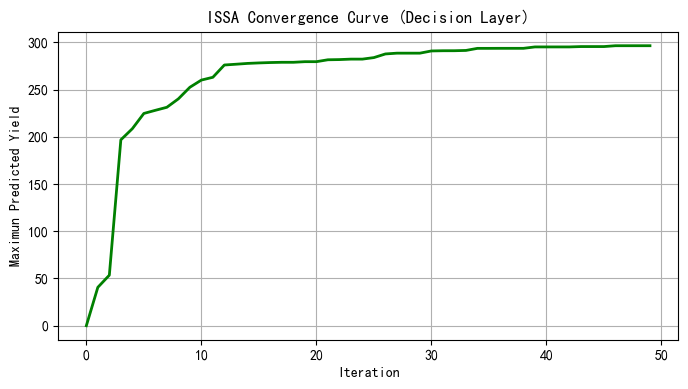

In [3]:
def decision_layer_objective(x):
    """
    决策层目标函数
    x: [目标温度, 目标湿度, 目标CO2, 目标光照]
    目标: 最大化 TPLC 预测产量 (因为 ISSA 是最小化 cost，所以取负的 yield)
    """
    # 确保输入在合理范围内（虽然优化器有边界，但模型可能敏感）
    predicted_growth = tplc_model.predict_yield(x)
    return -predicted_growth # Algorithm minimizes, so we return negative growth

# 定义优化边界 [Temp, Hum, CO2, Light]
# Temp: 15-35, Hum: 50-90, CO2: 400-1000, Light: 200-1000
lb_decision = [15, 50, 400, 200]
ub_decision = [35, 90, 1000, 1000]

print("Running Decision Layer Optimization with ISSA...")

# 初始化单目标优化器 ISSA
# pop_size=30, dim=4, max_iter=50
try:
    issa_decision = ISSAOptimizer(pop_size=30, dim=4, max_iter=50, lb=lb_decision, ub=ub_decision)
    
    # 执行优化
    best_setpoints, loss_history = issa_decision.optimize(decision_layer_objective)
    
    optimal_setpoints = best_setpoints
    max_predicted_yield = -loss_history[-1] # 转回正值
    
    print(f"Decision Layer Output (Optimal Setpoints):")
    print(f"  Temp: {optimal_setpoints[0]:.2f} C")
    print(f"  Hum : {optimal_setpoints[1]:.2f} %")
    print(f"  CO2 : {optimal_setpoints[2]:.2f} ppm")
    print(f"  Light: {optimal_setpoints[3]:.2f} lux")
    print(f"Max Predicted Yield Index: {max_predicted_yield:.4f}")

    # 绘制收敛曲线
    plt.figure(figsize=(8, 4))
    plt.plot([-y for y in loss_history], 'g-', linewidth=2) # Plot positive yield
    plt.title("ISSA Convergence Curve (Decision Layer)")
    plt.xlabel("Iteration")
    plt.ylabel("Maximun Predicted Yield")
    plt.grid(True)
    plt.show()
    
except NameError as e:
    print(f"Optimization failed: {e}. Defaulting to dummy values.")
    optimal_setpoints = [25.0, 70.0, 600.0, 500.0] 
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    optimal_setpoints = [25.0, 70.0, 600.0, 500.0]


## 3. 控制层 (Lower Layer): PID 参数多目标整定
获得最优设定值后，下层负责调整 PID 参数。这里引入**能耗模型**，利用 **MOSSA** 算法同时优化“跟踪精度”和“能源消耗”。

Optimizing PID for Target Temp: 24.30C with Multi-Objective MOSSA...
Iter 10/50 completed.
Iter 20/50 completed.
Iter 30/50 completed.
Iter 40/50 completed.
Iter 50/50 completed.
MOSSA Complete. Found 30 Pareto solutions.


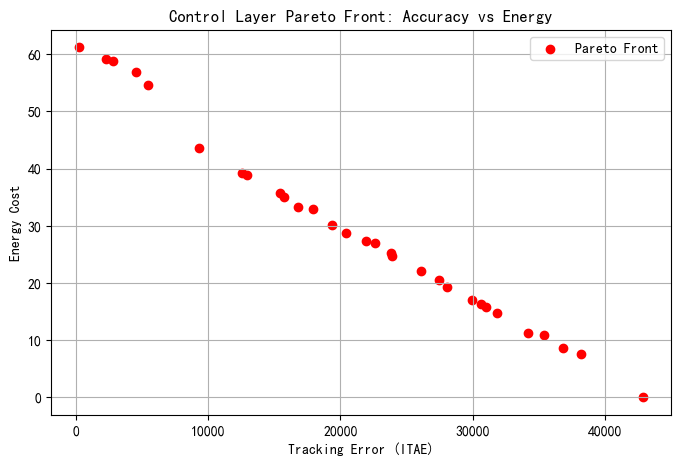

Selected PID (Accuracy Focus): Kp=10.00, Ki=1.79, Kd=1.04


In [4]:
class EnergyCostModel:
    def __init__(self):
        self.price_heat = 0.05 # per unit
        self.price_elec = 0.12 # per unit (cooling/fan)
        
    def calculate_cost(self, u_control):
        """
        计算单步能耗成本
        u_control: PID输出 (-100 ~ 100)
        """
        cost = 0.0
        # 假设 >0 加热, <0 制冷/通风
        if u_control > 0:
            power_heat = u_control * 0.5 
            cost += power_heat * self.price_heat
        else:
            power_cool = abs(u_control) * 0.2
            cost += power_cool * self.price_elec
        return cost

def control_layer_mo_objective(pid_params, target_val, steps=100):
    """
    控制层多目标函数
    pid_params: [Kp, Ki, Kd]
    Returns: [TraceError, EnergyCost]
    """
    kp, ki, kd = pid_params
    env = VirtualGreenhouse()
    pid = PIDController(kp, ki, kd)
    cost_model = EnergyCostModel()
    
    current_val = 20.0
    env.reset(init_temp=current_val)
    
    total_error = 0.0
    total_cost = 0.0
    
    for t in range(steps):
        error = abs(target_val - current_val)
        # ITAE (Integral of Time-weighted Absolute Error) for Error Metric
        total_error += (t + 1) * error
        
        control_signal = pid.update(target_val, current_val)
        
        # 累积能耗
        total_cost += cost_model.calculate_cost(control_signal)
        
        current_val = env.step(control_signal, 0.0)[0]
        
    return np.array([total_error, total_cost])

target_temp = optimal_setpoints[0]
print(f"Optimizing PID for Target Temp: {target_temp:.2f}C with Multi-Objective MOSSA...")

# PID 参数边界
lb_pid = [0.0, 0.0, 0.0]
ub_pid = [10.0, 5.0, 2.0]

# MOSSA Wrapper
def mo_pid_fitness(x):
    return control_layer_mo_objective(x, target_temp)

try:
    # 3-dim input (Kp,Ki,Kd), 2-dim output (Error, Cost)
    # MOSSA(obj_func, n_dim, lb, ub, pop_size=100, max_iter=100, n_obj=2)
    # 根据定义，MOSSA类在初始化时需要传入目标函数，而不是 optimize 方法
    mossa_control = MOSSA(obj_func=mo_pid_fitness, n_dim=3, lb=lb_pid, ub=ub_pid, pop_size=30, max_iter=50, n_obj=2)
    
    # Run Optimization
    # 注意: MOSSA 定义的方法名是 .run()，不是 .optimize()
    pareto_params, pareto_scores = mossa_control.run()
    
    print(f"MOSSA Complete. Found {len(pareto_params)} Pareto solutions.")
    
    # 可视化 Pareto 前沿
    plt.figure(figsize=(8, 5))
    plt.scatter(pareto_scores[:, 0], pareto_scores[:, 1], c='red', label='Pareto Front')
    plt.xlabel('Tracking Error (ITAE)')
    plt.ylabel('Energy Cost')
    plt.title('Control Layer Pareto Front: Accuracy vs Energy')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 策略选择：选择一个“折中”解 (Trade-off solution)
    # 简单方法：归一化后距离原点最近，或根据权重
    # 这里简单选 Error 最小的解（High Precision Mode）或者 中间点
    # Sort by Error
    sorted_indices = np.argsort(pareto_scores[:, 0])
    # Pick a balanced one (e.g., middle of the sorted list)
    chosen_idx = sorted_indices[0] # Chooses logical minimum error (Accuracy First)
    # chosen_idx = sorted_indices[len(sorted_indices)//2] # Balanced
    
    optimal_pid = pareto_params[chosen_idx]
    print(f"Selected PID (Accuracy Focus): Kp={optimal_pid[0]:.2f}, Ki={optimal_pid[1]:.2f}, Kd={optimal_pid[2]:.2f}")
    
except Exception as e:
    import traceback
    traceback.print_exc()
    print(f"MOSSA optimization failed ({e}), using default PID.")
    optimal_pid = [2.5, 0.1, 0.5]

## 4. 系统闭环验证
使用双层优化后的参数进行最终仿真。

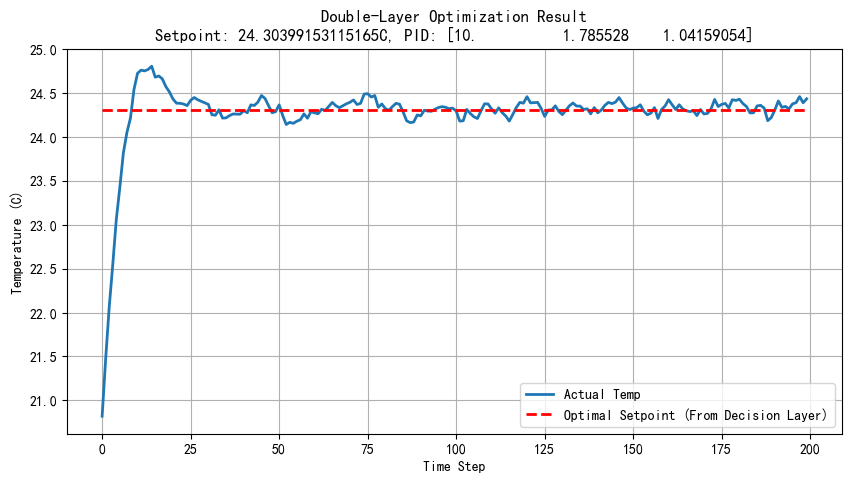

In [5]:
def run_simulation(setpoint, pid_params, steps=200):
    env = VirtualGreenhouse()
    pid = PIDController(kp=pid_params[0], ki=pid_params[1], kd=pid_params[2])
    
    current_temp = 20.0
    env.reset(init_temp=current_temp)
    
    history = []
    targets = []
    
    for _ in range(steps):
        control = pid.update(setpoint, current_temp)
        current_temp = env.step(control, 0.0)[0] # 仅控制温度
        history.append(current_temp)
        targets.append(setpoint)
        
    return history, targets

history, targets = run_simulation(target_temp, optimal_pid)

plt.figure(figsize=(10, 5))
plt.plot(history, label='Actual Temp', linewidth=2)
plt.plot(targets, 'r--', label='Optimal Setpoint (From Decision Layer)', linewidth=2)
plt.title(f"Double-Layer Optimization Result\nSetpoint: {target_temp}C, PID: {optimal_pid}")
plt.xlabel("Time Step")
plt.ylabel("Temperature (C)")
plt.legend()
plt.grid(True)
plt.show()

## 5. 架构可视化
为了更直观地展示“双层优化”流程，我们绘制如下架构图。该图展示了 TPLC 预测模型如何驱动决策层，以及决策层输出如何指导控制层进行参数寻优。

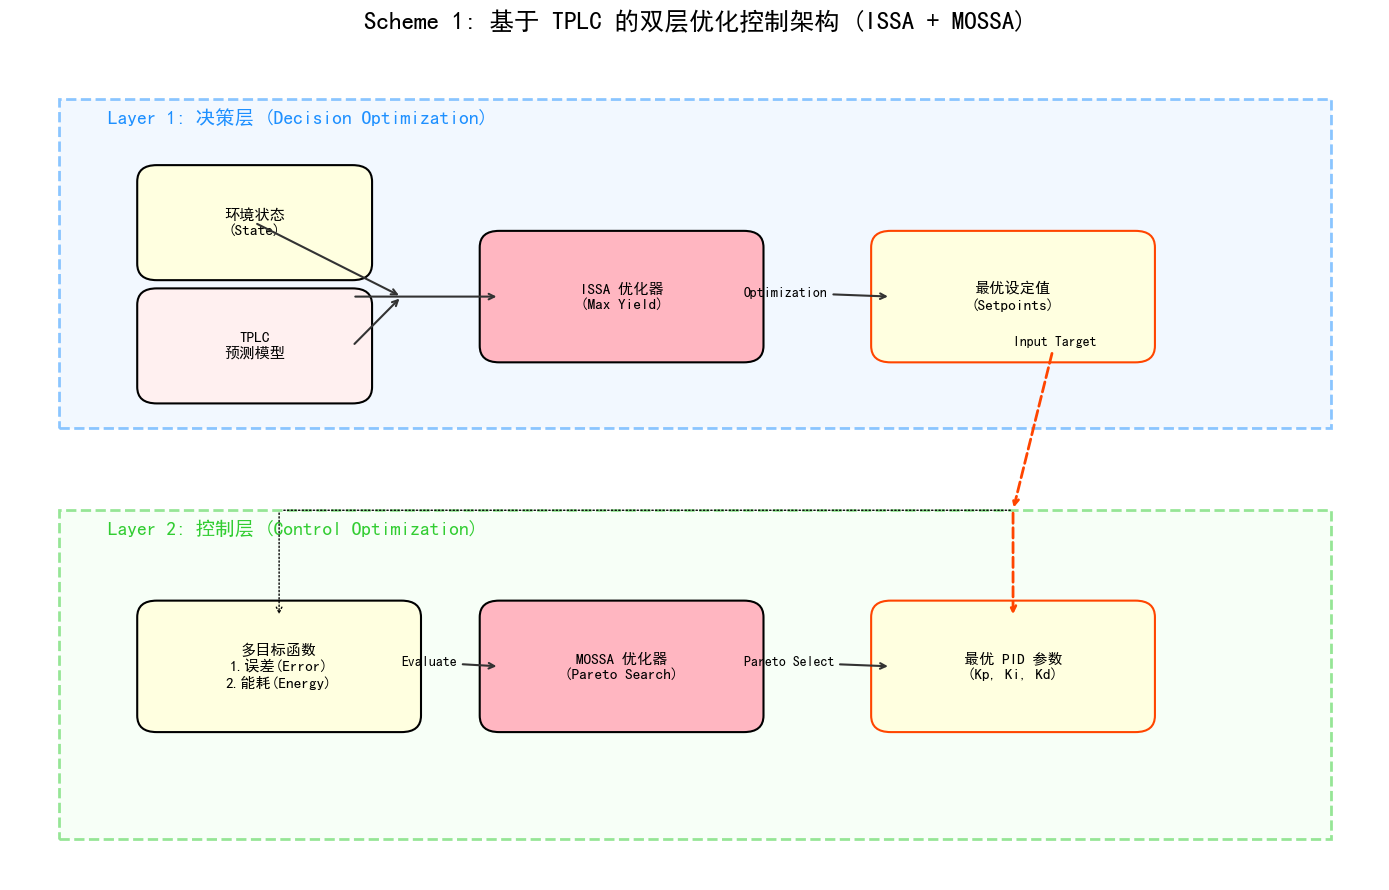

In [6]:
def  visualize_architecture():
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # 颜色定义
    c_decision = '#E6F3FF' # 决策层背景
    c_control = '#F0FFF0'  # 控制层背景
    c_process = '#FFF0F0'  # 核心处理模块
    c_data = '#FFFFE0'     # 数据/产出
    
    # --- 绘制区域 ---
    # 决策层区域
    rect_dec = patches.Rectangle((0.5, 5.5), 13, 4.0, linewidth=2, edgecolor='#1E90FF', facecolor=c_decision, linestyle='--', alpha=0.5)
    ax.add_patch(rect_dec)
    ax.text(1.0, 9.2, "Layer 1: 决策层 (Decision Optimization)", fontsize=14, fontweight='bold', color='#1E90FF')
    
    # 控制层区域
    rect_con = patches.Rectangle((0.5, 0.5), 13, 4.0, linewidth=2, edgecolor='#32CD32', facecolor=c_control, linestyle='--', alpha=0.5)
    ax.add_patch(rect_con)
    ax.text(1.0, 4.2, "Layer 2: 控制层 (Control Optimization)", fontsize=14, fontweight='bold', color='#32CD32')
    
    # --- 绘制节点 (Helper函数) ---
    def draw_box(x, y, w, h, text, color, ec='black'):
        box = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.2", linewidth=1.5, edgecolor=ec, facecolor=color)
        ax.add_patch(box)
        ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=11, fontweight='normal')
        return (x+w, y+h/2), (x, y+h/2), (x+w/2, y), (x+w/2, y+h) # Return connectors: right, left, bottom, top

    # Layer 1 Nodes (ISSA)
    _, _, p_env_b, _ = draw_box(1.5, 7.5, 2.0, 1.0, "环境状态\n(State)", c_data)
    _, _, p_tplc_b, _ = draw_box(1.5, 6.0, 2.0, 1.0, "TPLC\n预测模型", c_process)
    
    p_issa1_r, p_issa1_l, _, _ = draw_box(5.0, 6.5, 2.5, 1.2, "ISSA 优化器\n(Max Yield)", '#FFB6C1')
    
    # Output Setpoints
    p_set_r, p_set_l, p_set_b, _ = draw_box(9.0, 6.5, 2.5, 1.2, "最优设定值\n(Setpoints)", c_data, ec='#FF4500')
    
    # Layer 2 Nodes (Multi-Objective MOSSA)
    p_obj_r, _, p_obj_b, p_obj_t = draw_box(1.5, 2.0, 2.5, 1.2, "多目标函数\n1.误差(Error)\n2.能耗(Energy)", c_data)
    
    p_mossa2_r, p_mossa2_l, _, p_mossa2_t = draw_box(5.0, 2.0, 2.5, 1.2, "MOSSA 优化器\n(Pareto Search)", '#FFB6C1')
    
    _, p_pid_l, _, p_pid_t = draw_box(9.0, 2.0, 2.5, 1.2, "最优 PID 参数\n(Kp, Ki, Kd)", c_data, ec='#FF4500')

    # --- 绘制连接线 ---
    props = dict(arrowstyle='->', linewidth=1.5, color='#333333')
    
    # L1 Internal
    ax.annotate("", xy=p_issa1_l, xytext=(3.5, 7.1), arrowprops=props)
    ax.annotate("", xy=(4.0, 7.1), xytext=(2.5, 8.0), arrowprops=props)
    ax.annotate("", xy=(4.0, 7.1), xytext=(3.5, 6.5), arrowprops=props)
    ax.annotate("Optimization", xy=p_set_l, xytext=p_issa1_r, arrowprops=props)
    
    # Cross Layer
    ax.annotate("Input Target", xy=(10.25, 4.5), xytext=p_set_b, arrowprops=dict(arrowstyle='->', linewidth=2, color='#FF4500', linestyle='--'))
    ax.annotate("", xy=p_pid_t, xytext=(10.25, 4.5), arrowprops=dict(arrowstyle='->', linewidth=2, color='#FF4500', linestyle='--'))
    
    # L2 Flow
    # Setpoint to Objective
    ax.annotate("", xy=p_obj_t, xytext=(2.75, 4.5), arrowprops=dict(arrowstyle='->', lw=1, ls=':'))
    ax.annotate("", xy=(2.75, 4.5), xytext=(10.25, 4.5), arrowprops=dict(arrowstyle='-', lw=1, ls=':'))
    
    ax.annotate("Evaluate", xy=p_mossa2_l, xytext=p_obj_r, arrowprops=props)
    ax.annotate("Pareto Select", xy=p_pid_l, xytext=p_mossa2_r, arrowprops=props)
    
    plt.title("Scheme 1: 基于 TPLC 的双层优化控制架构 (ISSA + MOSSA)", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()

visualize_architecture()